In [1]:
import time
import torch
import random
import argparse
from torch.utils.data import DataLoader
import numpy as np
import os
import gc
import time
import sys
from tqdm.notebook import tqdm as blue_tqdm
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from tqdm import tqdm
import wandb
import subprocess

In [2]:
# import Datasets and Networks
from dataset.dataset_inference_class_ss8_premask import Proteins_Dataset_Class
from dataset.dataset_inference_test_ss8_premask import Proteins_Dataset_Test


from models_train.bilstm_more import Network
from models_train.ms_resnet_more1 import Network as Network2
from models_train.ms_res_lstm_more import Network as Network3
SS8_CLASSES = ['C', 'S', 'T', 'H', 'G', 'I', 'E', 'B']  # Define your SS8 classes

"""
latest file fixed validate and train method
"""
# DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
# DEVICE = "cuda:1"
DEVICE = "cpu"
print("Device: ", DEVICE)

Device:  cpu


In [3]:
# hyperparameters
config = dict(
    file_path       = "spot_1d_lm/lists/",
    file_list_data  = "files.txt",
    file_list_train = "train.txt",
    file_list_val   = "val.txt",
    file_list_test  = "casp14.txt",
    batch_size      = 10, #10
    epoch           = 50,
    loss            = torch.nn.CrossEntropyLoss(ignore_index=-1).to(DEVICE),
    learning_rate   = 1e-3,
    run             = 18,
    vbatch_size     = 5,
    tbatch_size     = 1,
    weight_decay    = 1e-2, # 1e-5 to 1
    lr_mode         = 'min',
    lr_factor       = 0.8,
    lr_patience     = 3,
    lr_threshold    = 1e-3,
    lr_verbose      = True,
    l1_coeff        = 1e-5
)


In [4]:
def read_and_split_file(file_path, file_name_lists, train_ratio=0.9):
    # Read the list of protein names
    with open(os.path.join(file_path, file_name_lists), 'r') as file:
        protein_names = file.readlines()
    
    # Remove any trailing newline characters
    protein_names = [name.strip() for name in protein_names]

    # Shuffle the list
    random.shuffle(protein_names)

    # Calculate the split index
    split_index = int(len(protein_names) * train_ratio)

    # Split the list into training and validation
    train_list = protein_names[:split_index]
    val_list = protein_names[split_index:]

    # Save the training and validation lists
    with open(os.path.join(file_path, 'train.txt'), 'w') as file:
        for name in train_list:
            file.write(name + '\n')

    with open(os.path.join(file_path, 'val.txt'), 'w') as file:
        for name in val_list:
            file.write(name + '\n')
# end def

read_and_split_file(config['file_path'], config['file_list_data'])

In [5]:
# valid_dataset       = Proteins_Dataset_Class(
#     file_name_list  = os.path.join(config['file_path'], config["file_list_val"])
# )
test_dataset        = Proteins_Dataset_Test(
    file_name_list  = os.path.join(config['file_path'], config["file_list_test"])
)

gc.collect()

# valid_loader    = DataLoader(
#     dataset     = valid_dataset,
#     batch_size  = config['vbatch_size'],
#     shuffle     = False,
#     num_workers = 2,
#     pin_memory  = False, # True
#     collate_fn  = valid_dataset.text_collate_fn
# )

test_loader     = DataLoader(
    dataset     = test_dataset,
    batch_size  = config['tbatch_size'],
    shuffle     = False,
    num_workers = 2,
    pin_memory  = False,
    collate_fn  = test_dataset.text_collate_fn
)

In [6]:
torch.cuda.empty_cache()
gc.collect()
print("Batch size           : ", config['batch_size'])
# print("Valid batches        : ", valid_loader.__len__())
print("Test batches         : ", test_loader.__len__())

print("\nChecking the shapes of the data...")


torch.cuda.empty_cache()
gc.collect()

Batch size           :  10
Test batches         :  15

Checking the shapes of the data...


0

In [7]:
def load_model(best_path, epoch_path, model, mode= 'best', metric= 'valid_acc', optimizer= None, scheduler= None):

    if mode == 'best':
        checkpoint  = torch.load(best_path)
        print("Loading best checkpoint: ", checkpoint[metric])
    else:
        checkpoint  = torch.load(epoch_path)
        print("Loading epoch checkpoint: ", checkpoint[metric])

    model.load_state_dict(checkpoint['model_state_dict'], strict= False)

    if optimizer != None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        #optimizer.param_groups[0]['lr'] = 1.5e-3
        optimizer.param_groups[0]['weight_decay'] = 1e-5
    if scheduler != None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    epoch   = checkpoint['epoch']
    metric  = torch.load(best_path)[metric]

    return [model, optimizer, scheduler, epoch, metric]
# end def

In [8]:
torch.cuda.empty_cache()
gc.collect()

model1 = Network(input_size=2862, num_classes=len(SS8_CLASSES))
model2 = Network2(input_channel=2862, num_classes=len(SS8_CLASSES))
model3 = Network3(input_channel=2862, num_classes=len(SS8_CLASSES))

In [9]:
class EnsembleNetwork(torch.nn.Module):
    def __init__(self, model1, model2, model3):
        super(EnsembleNetwork, self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
        self.softmax = torch.nn.Softmax(dim=1)
    # end def

    def forward(self, x, x_lens):
        # Get outputs from each model
        out1 = self.model1(x, x_lens)
        out2 = self.model2(x, x_lens)
        out3 = self.model3(x, x_lens)

        # # Apply softmax
        # result = self.softmax(avg_out)
        return out1, out2, out3
    # end def
# end class

In [10]:
torch.cuda.empty_cache()
gc.collect()

model = EnsembleNetwork(model1, model2, model3)
# model = EnsembleNetwork(model2)
model = model.to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

optimizer   = torch.optim.AdamW(model.parameters(), 
                               lr           = config['learning_rate'], 
                               weight_decay = config['weight_decay'])
criterion   = config['loss']
# scaler      = torch.cuda.amp.GradScaler()  # Initialize the gradient scaler for mixed-precision training
scheduler   = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                         mode=config['lr_mode'], 
                                                         factor= config['lr_factor'], 
                                                         patience=config['lr_patience'], 
                                                         verbose=config['lr_verbose'],
                                                         threshold=config['lr_threshold'])

Total number of parameters: 160477544


In [11]:
def validate(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    total_loss  = 0
    total_samples = 0
    total_correct = 0

    # with torch.no_grad():  # Disable gradient computation
    for i, batch in enumerate(dataloader):
        x, y, lengths, protein_names, sequences = batch
        x, y = x.to(DEVICE), y.to(DEVICE)

        # get model outputs
        with torch.inference_mode():
            output1, output2, output3 = model(x, lengths)
            outputs = torch.stack([output1, output2, output3], dim=0)
            outputs = torch.mean(outputs, dim=0)
            # Change shape to [batch_size, num_classes, sequence_length]
            outputs = outputs.permute(0, 2, 1)   

            # Create a 3D mask that matches the outputs tensor shape
            predictions = torch.argmax(outputs, dim=1)
            mask = y != -1  # Create a mask for non-padded values
            correct_predictions = (predictions == y) & mask  # Apply mask
            samples = mask.sum().item()
            total_correct += correct_predictions.sum().item()
            accuracy = correct_predictions.sum().item() / samples
            
            loss    = criterion(outputs, y)
        # end with

        total_samples   += samples
        total_loss      += float(loss.item())

        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(float(100 * accuracy)),
            loss        = "{:.04f}".format(float(total_loss / (i + 1)))
        )

        batch_bar.update()
        del x, y, lengths, protein_names, sequences
        # del loss, accuracy, samples, correct_predictions, mask, predictions
        torch.cuda.empty_cache()
        
    # end for

    batch_bar.close()

    acc        = float(100 * total_correct / total_samples)
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss
# end def


In [12]:
# model, optimizer, scheduler, epoch, metric = load_model("checkpoint_pb_12_13.pth", "checkpoint_pb_12_13.pth", model, "best", optimizer, scheduler)
checkpoint = torch.load("checkpoint.pth", map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [13]:
def testing(model, dataloader):
    model.eval()  # Set the model to evaluation mode

    total_samples = 0
    total_correct = 0
    lprotein_names, llengths, lsequences, loutputs, ly, laccuracy = [], [], [], [], [], []

    # with torch.no_grad():  # Disable gradient computation
    for i, batch in enumerate(dataloader):
        x, y, lengths, protein_names, sequences = batch
        x, y = x.to(DEVICE), y.to(DEVICE)

        # get model outputs
        with torch.inference_mode():
            output1, output2, output3 = model(x, lengths)
            outputs = torch.stack([output1, output2, output3], dim=0)
            outputs = torch.mean(outputs, dim=0)
            # Change shape to [batch_size, num_classes, sequence_length]
            outputs = outputs.permute(0, 2, 1)  

            # Create a 3D mask that matches the outputs tensor shape
            predictions = torch.argmax(outputs, dim=1)
            mask = y != -1  # Create a mask for non-padded values

            predictions = predictions[mask]
            y = y[mask]
            # print(predictions.shape)
            # print(y.shape)
            # print(mask.shape)


            correct_predictions = predictions == y  # Apply mask
            samples = mask.sum().item()
            total_correct += correct_predictions.sum().item()
            accuracy = correct_predictions.sum().item() / samples
            lprotein_names.append(protein_names[0])
            llengths.append(lengths.tolist()[0])
            lsequences.append(sequences[0])
            loutputs.append(predictions.tolist())
            ly.append(y.tolist())
            laccuracy.append(accuracy)
        # end with
        total_samples   += samples
        del x
        torch.cuda.empty_cache()
        
    # end for
    return lprotein_names, llengths, lsequences, loutputs, ly, laccuracy
# end def

In [14]:
protein_names, lengths, sequences, outputs, y, accuracy = testing(model, test_loader)
seq = "ACDEFGHIKLMNPQRSTVWY-X"

In [15]:
print(protein_names[0], lengths[0], sequences[0], outputs[0], y[0])

T1027-D1 168 KPTENNEDFNIVAVASNFATTDLDADRGKLPGKKLPLEVLKEMEANARKAGCTRGCLICLSHIKCTPKMKKFIPGRCHTYEGDKESAQGGIGEAIVDIPAIPRFKDLEPMEQFIAQVDLCVDCTTGCLKGLANVQCSDLLKKWLPQRCATFASKIQGQVDKIKGAGGD [0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 1, 0, 2, 0, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0] [0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 2, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 1, 2, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 7, 2, 2, 7, 1, 4, 4, 4, 4, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0]


In [16]:
print(SS8_CLASSES)

['C', 'S', 'T', 'H', 'G', 'I', 'E', 'B']


In [17]:
seq = "ACDEFGHIKLMNPQRSTVWY"

# SS8_CLASSES = ['C', 'S', 'T', 'H', 'G', 'I', 'E', 'B']
from sklearn.metrics import confusion_matrix
import seaborn as sns

# cm = confusion_matrix(y[2], outputs[2])

# plt.figure(figsize=(8, 6))
# # sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=SS8_CLASSES, yticklabels=SS8_CLASSES)
# sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
# plt.ylabel('Actual', fontsize=12)
# plt.xlabel('Predicted', fontsize=12)
# plt.title('Confusion Matrix', fontsize=14)
# plt.show()


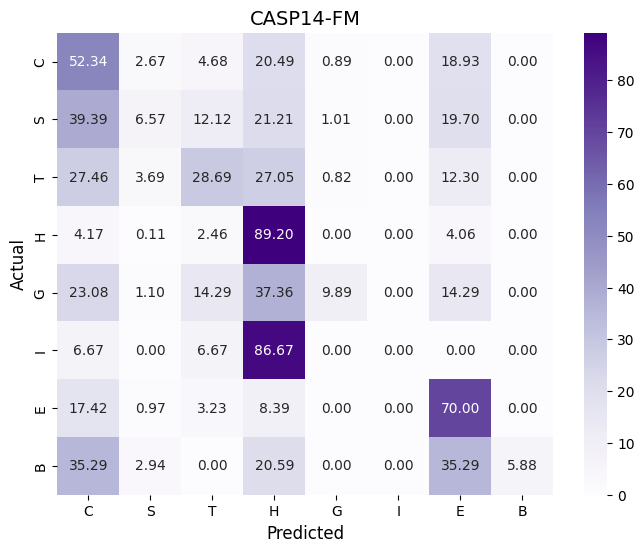

In [18]:
# Flatten the lists
y_flat = np.concatenate(y)
outputs_flat = np.concatenate(outputs)

# Compute the confusion matrix
cm = confusion_matrix(y_flat, outputs_flat)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=SS8_CLASSES, yticklabels=SS8_CLASSES)
sns.heatmap(cm_normalized*100, annot=True, fmt=".2f", cmap="Purples", xticklabels=SS8_CLASSES, yticklabels=SS8_CLASSES)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title(f'{config["file_list_test"][:-4].upper()}-FM', fontsize=14)
plt.show()

In [19]:
def calculate_accuracies(sequences, outputs, y, all_possible_sequences):
    accuracies = {aa: {'correct': 0, 'total': 0} for aa in all_possible_sequences}

    for sequence, output, true in zip(sequences, outputs, y):
        for aa, pred, true_val in zip(sequence, output, true):
            if aa in accuracies:
                accuracies[aa]['total'] += 1
                if pred == true_val:
                    accuracies[aa]['correct'] += 1

    average_accuracies = {aa: (info['correct'] / info['total']) if info['total'] > 0 else 0 for aa, info in accuracies.items()}
    return average_accuracies

# Example usage
all_possible_sequences = "ACDEFGHIKLMNPQRSTVWY"
average_accuracies = calculate_accuracies(sequences, outputs, y, all_possible_sequences)
print(average_accuracies)

{'A': 0.6956521739130435, 'C': 0.2857142857142857, 'D': 0.6111111111111112, 'E': 0.6130952380952381, 'F': 0.6220472440944882, 'G': 0.5, 'H': 0.525, 'I': 0.6981132075471698, 'K': 0.6052631578947368, 'L': 0.6391752577319587, 'M': 0.7837837837837838, 'N': 0.531578947368421, 'P': 0.4939759036144578, 'Q': 0.625, 'R': 0.7, 'S': 0.5519125683060109, 'T': 0.5864661654135338, 'V': 0.6532258064516129, 'W': 0.7, 'Y': 0.6571428571428571}


In [20]:
print(np.average(accuracy))

0.6135417825692226


In [21]:
import pandas as pd

In [22]:
os.path.join(config['file_path'], config["file_list_test"])

'spot_1d_lm/lists/casp14.txt'

In [23]:
print(protein_names)

['T1027-D1', 'T1029-D1', 'T1031-D1', 'T1033-D1', 'T1035-D1', 'T1037-D1', 'T1038-D1', 'T1038-D2', 'T1039-D1', 'T1040-D1', 'T1041-D1', 'T1042-D1', 'T1043-D1', 'T1046s1-D1', 'T1049-D1']


In [24]:
def calculate_spot_accuracies(protein_names, all_possible_sequences):
    total_samples = 0.0
    total_correct = 0.0
    accuracies = {aa: {'correct': 0, 'total': 0} for aa in all_possible_sequences}
    outputs = []
    y = []
    for protein in protein_names:
        results_file_name = os.path.join("results/", protein + '.csv')
        labels_file_name  = os.path.join("spot_1d_lm/labels/", protein + '.npy')
        labels            = np.load(labels_file_name, allow_pickle=True)
        true              = np.array([SS8_CLASSES.index(aa) if aa in SS8_CLASSES else -1 for aa in labels[:,4]])
        output            = np.array([SS8_CLASSES.index(aa) if aa in SS8_CLASSES else -1 for aa in pd.read_csv(results_file_name)['SS8'].to_numpy()])
        vidx = np.where(true != -1)[0]
        sequence          = ''.join(labels[vidx, 3])
        true = true[vidx]
        y.append(true)
        output = output[vidx]
        outputs.append(output)
        total_samples += len(vidx)

        for aa, pred, true_val in zip(sequence, output, true):
            if aa in accuracies:
                accuracies[aa]['total'] += 1
                if pred == true_val:
                    accuracies[aa]['correct'] += 1
                    total_correct +=1

    average_accuracies = {aa: (info['correct'] / info['total']) if info['total'] > 0 else 0 for aa, info in accuracies.items()}
    return average_accuracies, total_correct/total_samples, outputs, y

# Example usage
all_possible_sequences = "ACDEFGHIKLMNPQRSTVWY"
average_spot_accuracies, acc, outputs, y = calculate_spot_accuracies(protein_names, all_possible_sequences)
print(average_spot_accuracies)
print(f'average accuracy: {acc}')

{'A': 0.6847826086956522, 'C': 0.5652173913043478, 'D': 0.6267605633802817, 'E': 0.625, 'F': 0.6717557251908397, 'G': 0.496, 'H': 0.4523809523809524, 'I': 0.725, 'K': 0.6387434554973822, 'L': 0.6530612244897959, 'M': 0.825, 'N': 0.521505376344086, 'P': 0.5662650602409639, 'Q': 0.6582278481012658, 'R': 0.7391304347826086, 'S': 0.6033519553072626, 'T': 0.5984848484848485, 'V': 0.704, 'W': 0.8, 'Y': 0.6796116504854369}
average accuracy: 0.6318101933216169


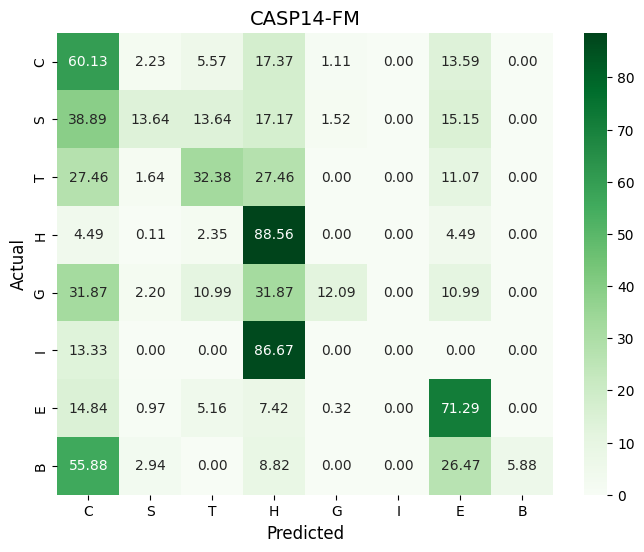

In [25]:
# Flatten the lists
y_flat = np.concatenate(y)
outputs_flat = np.concatenate(outputs)

# Compute the confusion matrix
cm = confusion_matrix(y_flat, outputs_flat)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=SS8_CLASSES, yticklabels=SS8_CLASSES)
sns.heatmap(cm_normalized*100, annot=True, fmt=".2f", cmap="Greens", xticklabels=SS8_CLASSES, yticklabels=SS8_CLASSES)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title(f'{config["file_list_test"][:-4].upper()}-FM', fontsize=14)
plt.show()

In [25]:

# Calculate the percent difference between the two dictionaries per key
percent_differences = {key: (average_spot_accuracies[key] - average_accuracies[key]) / 
                       average_accuracies[key] * 100 for key in average_accuracies}

percent_differences

{'A': 0.27932960893855013,
 'C': -3.278688524590173,
 'D': 11.872897469650438,
 'E': 1.205075871860864,
 'F': 4.6277665995976,
 'G': -17.41182314952807,
 'H': 1.6685956790123493,
 'I': 2.586316728245629,
 'K': 2.0243226600985267,
 'L': 11.546510955657048,
 'M': 3.7186276767211544,
 'N': -3.7161185921516524,
 'P': 14.095425264766886,
 'Q': -3.8647342995169143,
 'R': 0.4334824636639759,
 'S': -1.1173097543161763,
 'T': 0.0,
 'V': 3.760809267417193,
 'W': 1.6501650165016466,
 'Y': 5.144032921810692}

In [26]:
average_spot_accuracies = {key: value * 100 for key, value in average_spot_accuracies.items()}
average_accuracies = {key: value * 100 for key, value in average_accuracies.items()}

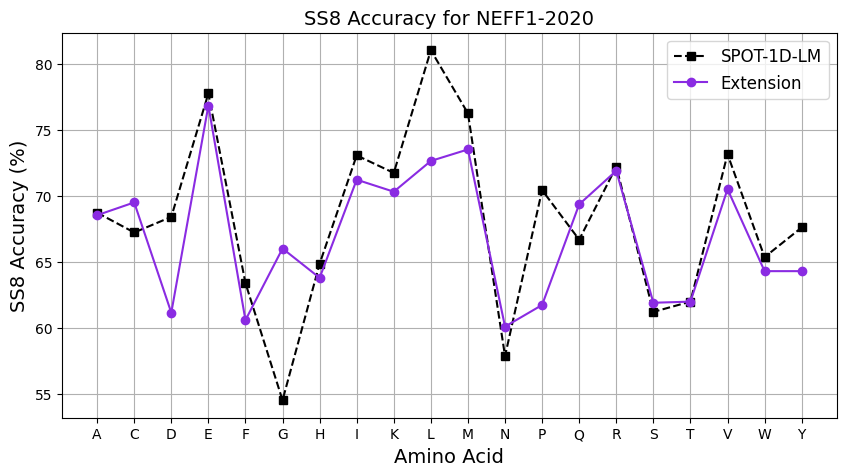

<Figure size 640x480 with 0 Axes>

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(list(average_spot_accuracies.keys()), list(average_spot_accuracies.values()), marker='s', color='black', linestyle='--', label='SPOT-1D-LM')
plt.plot(list(average_accuracies.keys()), list(average_accuracies.values()), marker='o', color='#8A2BE2', linestyle='-', label='Extension')
plt.xlabel('Amino Acid', fontsize=14)
plt.ylabel('SS8 Accuracy (%)', fontsize=14)
plt.title(f'SS8 Accuracy for {config["file_list_test"][:-4].upper()}', fontsize=14)

plt.grid(True)
plt.legend(fontsize=12)
plt.show()
plt.savefig(config["file_list_test"][:-4]+'-run-12.png')

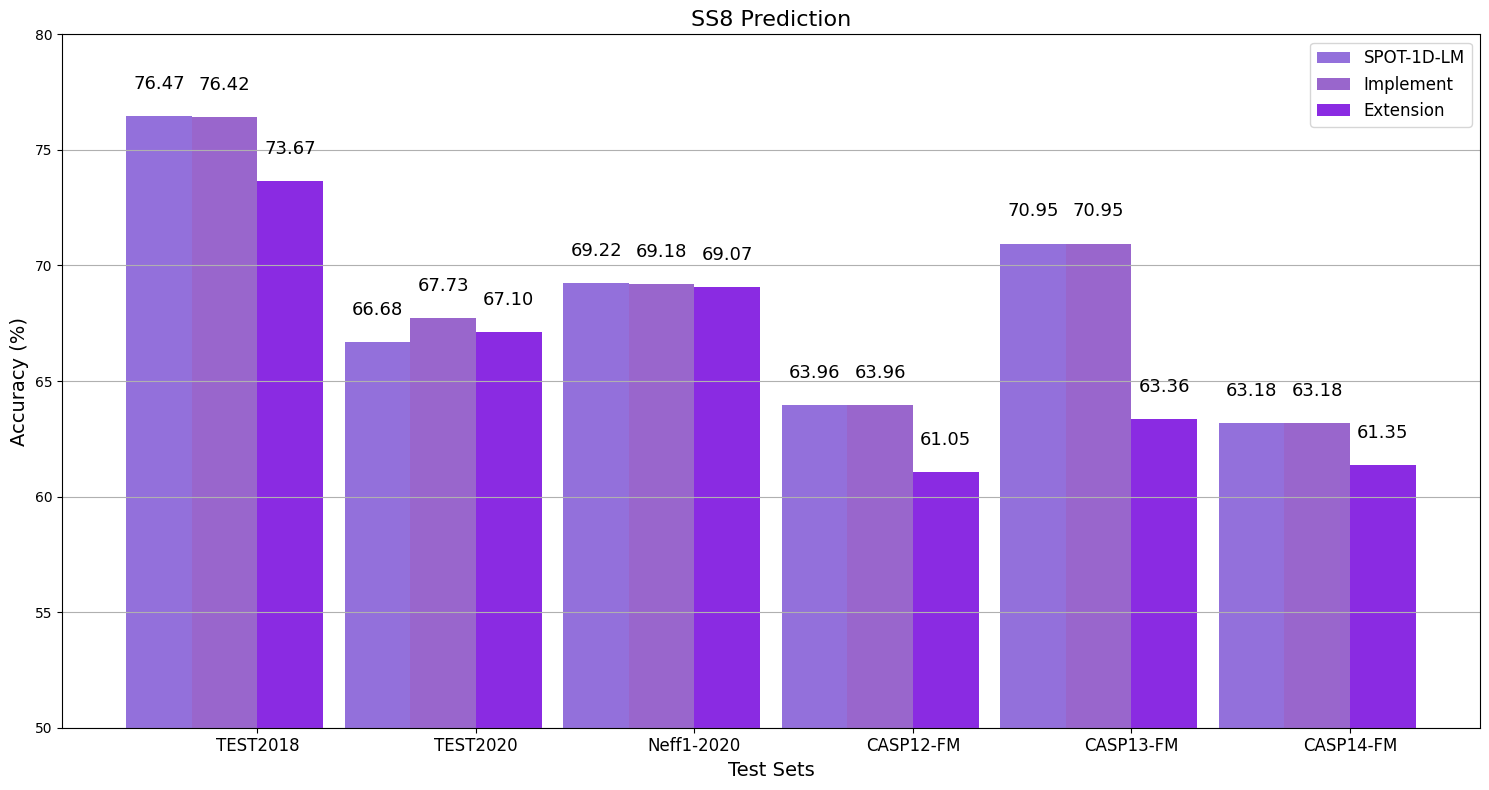

In [29]:
# Adjusting the bar plots to be wider, the text bigger, and the y-axis to start from 50

# Sample data
test_sets = ['TEST2018', 'TEST2020', 'Neff1-2020', 'CASP12-FM', 'CASP13-FM', 'CASP14-FM']
models = ['SPOT-1D-LM', 'Implement', 'Extension']
data = np.array([[76.47, 76.42, 73.67], [66.68, 67.73, 67.10], [69.22, 69.18, 69.07], [63.96, 63.96, 61.05], [70.95, 70.95, 63.36], [63.18, 63.18, 61.35]])

num_models = len(models)
x = np.arange(len(test_sets))  # the label locations
width = 0.30  # the width of the bars

# Colors for the gradient
colors = ['#9370DB', '#9966CC', '#8A2BE2']  # Different shades of purple

fig, ax = plt.subplots(figsize=(15, 8))  # Adjusted for better visual representation
ax.grid(axis='y')
for i in range(num_models):
    ax.bar(x - (num_models / 2 - i) * width, data[:, i], width, label=models[i], color=colors[i])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)', fontsize=14)
ax.set_xlabel('Test Sets', fontsize=14)
ax.set_title('SS8 Prediction', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(test_sets, fontsize=12)
ax.legend(fontsize=12)
ax.set_ylim(50, 80)  # Set the start of the y-axis to 50

# Add the text with the value on top of each bar
for i in range(len(test_sets)):
    for j in range(num_models):
        ax.text(i + (j - num_models / 2) * width, data[i, j] + 1, f'{data[i, j]:.2f}',
                ha='center', va='bottom', fontsize=13)

fig.tight_layout()

plt.show()

